In [1]:
!nvidia-smi

Fri Jul  5 01:55:02 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.171.04             Driver Version: 535.171.04   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A30                     Off | 00000000:01:00.0 Off |                   On |
| N/A   33C    P0              26W / 165W |     50MiB / 24576MiB |     N/A      Default |
|                                         |                      |              Enabled |
+-----------------------------------------+----------------------+--

In [2]:
from dataclasses import dataclass
from functools import partial
from math import floor 
from typing import Callable, Tuple, Any

import jax
from jax import debug
import jax.numpy as jnp
import flax.linen as nn
import optax
from chex import ArrayTree
from qdax.core.containers.repertoire import Repertoire
from qdax.types import Descriptor, ExtraScores, Fitness, Genotype, RNGKey
from qdax.environments.base_wrappers import QDEnv
from qdax.core.neuroevolution.buffers.buffer import QDTransition, QDMCTransition
#from qdax.core.neuroevolution.buffers.trajectory_buffer import TrajectoryBuffer
import flashbax as fbx
import chex
from rein_related import *

from qdax.core.emitters.emitter import Emitter, EmitterState

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7a9fec10c3d0>>
Traceback (most recent call last):
  File "/vol/bitbucket/km2120/QD-DRL/me-with-sample-based-drl/my_env/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


In [3]:
EPS = 1e-8


@dataclass
class MCPGConfig:
    """Configuration for the REINaive emitter.
    """
    no_agents: int = 256
    batch_size: int = 1000*256
    mini_batch_size: int = 1000*256
    no_epochs: int = 16
    learning_rate: float = 3e-4
    discount_rate: float = 0.99
    adam_optimizer: bool = True
    buffer_size: int = 256000
    clip_param: float = 0.2
    
class MCPGEmitterState(EmitterState):
    """Contains the trajectory buffer.
    """
    #buffer: Any
    buffer_state: Any
    random_key: RNGKey
    
class MCPGEmitter(Emitter):
    
    def __init__(
        self,
        config: MCPGConfig,
        policy_net: nn.Module,
        env: QDEnv,
    ) -> None:
        
        self._config = config
        self._policy = policy_net
        self._env = env
        
        self._policy_opt = optax.adam(
            learning_rate=self._config.learning_rate
        )
        buffer = fbx.make_trajectory_buffer(
            max_length_time_axis=self._env.episode_length,
            min_length_time_axis=self._env.episode_length,
            sample_batch_size=2*self._config.no_agents,
            add_batch_size=2*self._config.no_agents,
            sample_sequence_length=self._env.episode_length,
            period=self._env.episode_length,
        )
        self._buffer = buffer
        
    @property
    def batch_size(self) -> int:
        """
        Returns:
            int: the batch size emitted by the emitter.
        """
        return self._config.no_agents
    
    @property
    def use_all_data(self) -> bool:
        """Whther to use all data or not when used along other emitters.
        """
        return True
    
    @partial(jax.jit, static_argnames=("self",))
    def init(
        self,
        random_key: RNGKey,
        repertoire: Repertoire,
        genotypes: Genotype,
        fitnesses: Fitness,
        descriptors: Descriptor,
        extra_scores: ExtraScores,
    ) -> Tuple[MCPGEmitterState, RNGKey]:
        """Initializes the emitter state.
        """
        obs_size = self._env.observation_size
        action_size = self._env.action_size
        descriptor_size = self._env.state_descriptor_length
        
        # Init trajectory buffer
        dummy_transition = QDMCTransition.init_dummy(
            observation_dim=obs_size,
            action_dim=action_size,
            descriptor_dim=descriptor_size,
        )
        '''
        buffer = fbx.make_trajectory_buffer(
            max_length_time_axis=self._env.episode_length,
            min_length_time_axis=self._env.episode_length,
            sample_batch_size=self._config.no_agents,
            add_batch_size=self._config.no_agents,
            sample_sequence_length=self._env.episode_length,
            period=self._env.episode_length,
        )
        '''
        
        buffer_state = self._buffer.init(dummy_transition)
        
        '''
        buffer = TrajectoryBuffer.init(
            buffer_size=self._config.buffer_size,
            transition=dummy_transition,
            env_batch_size=self._config.no_agents*2,
            episode_length=self._env.episode_length,
        )
        '''
        
        random_key, subkey = jax.random.split(random_key)
        emitter_state = MCPGEmitterState(
            #buffer=buffer,
            buffer_state=buffer_state,
            random_key=subkey,
        )
        #ßprint(emitter_state)
        
        return emitter_state, random_key
    
    @partial(jax.jit, static_argnames=("self",))
    def emit(
        self,
        repertoire: Repertoire,
        emitter_state: MCPGEmitterState,
        random_key: RNGKey,
    ) -> Tuple[Genotype, RNGKey]:
        """Do a step of MCPG emission.
        """
        
        no_agents = self._config.no_agents
        
        # sample parents
        parents, random_key = repertoire.sample(
            random_key=random_key,
            num_samples=no_agents,
        )
        
        offsprings_mcpg = self.emit_mcpg(emitter_state, parents)
        
        return offsprings_mcpg, {}, random_key
    
    @partial(jax.jit, static_argnames=("self",))
    def emit_mcpg(
        self,
        emitter_state: MCPGEmitterState,
        parents: Genotype,
    ) -> Genotype:
        """Emit the offsprings generated through MCPG mutation.
        """
        
        mutation_fn = partial(
            self._mutation_function_mcpg,
            emitter_state=emitter_state,
        )
        
        offsprings = jax.vmap(mutation_fn)(parents)
        
        return offsprings
    
    @partial(jax.jit, static_argnames=("self",))
    def state_update(
        self,
        emitter_state: MCPGEmitterState,
        repertoire: Optional[Repertoire],
        genotypes: Optional[Genotype],
        fitnesses: Optional[Fitness],
        descriptors: Optional[Descriptor],
        extra_scores: ExtraScores,
    ) -> MCPGEmitterState:
        """Update the emitter state.
        """
        
        random_key, _ = jax.random.split(emitter_state.random_key)
        
        assert "transitions" in extra_scores.keys(), "Missing transtitions or wrong key"
        transitions = extra_scores["transitions"]
        new_buffer_state = self._buffer.add(emitter_state.buffer_state, transitions)
        new_emitter_state = emitter_state.replace(random_key=random_key, buffer_state=new_buffer_state)
        
        return new_emitter_state
        
        # update the buffer
        '''
        replay_buffer = emitter_state.buffer.insert(transitions)
        emitter_state = emitter_state.replace(buffer=replay_buffer)
        
        return emitter_state
        '''
    
    @partial(jax.jit, static_argnames=("self",))
    def compute_mask(
        self,
        done,
    ):
        return 1. - jnp.clip(jnp.cumsum(done), a_min=0., a_max=1.)
    '''
    @partial(jax.jit, static_argnames=("self",))
    def compute_logps(
        self,
        policy_params,
        obs,
        actions,
    ):
        """Compute the log probabilities of the actions.
        """
        compute_logp = partial(
            self._policy.apply,
            params=policy_params,
            method=self._policy.logp,
        )
        
        return jax.vmap(compute_logp)(obs, actions)
    '''
    
    @partial(jax.jit, static_argnames=("self",))
    def compute_logps(self, policy_params, obs, actions):
        def compute_logp(single_obs, single_action):
            # Correctly handle operations on single_obs and single_action
            # Ensure no inappropriate method calls like .items() are made
            return self._policy.apply(policy_params, single_obs, single_action, method=self._policy.logp)

        # Use jax.vmap to apply compute_logp across batches of obs and actions
        return jax.vmap(compute_logp, in_axes=(0, 0))(obs, actions)
       
    @partial(jax.jit, static_argnames=("self",))
    def get_return(
        self,
        rewards,
    ):
        def _body(carry, x):
            (next_return,) = carry
            (rewards,) = x

            current_return = rewards + self._config.discount_rate * next_return
            return (current_return,), (current_return,)
        
        
        
        #jax.debug.print("rewards", rewards.shape)
        
        _, (return_,) = jax.lax.scan(
            _body,
            (jnp.array(0.),),
            (rewards,),
            length=self._env.episode_length,
            reverse=True,
        )
        
        return return_
    
    
    '''
    @partial(jax.jit, static_argnames=("self",))
    def get_return(self, rewards):
        def _body(carry, reward):
            next_return = carry  # carry should be unpacked directly if it's a single element
            current_return = reward + self._config.discount_rate * next_return
            return current_return, current_return  # Maintain the same shape and type

        initial_return = jnp.array(0.0)  # Ensure initial_return is correctly shaped as a scalar
        _, return_ = jax.lax.scan(
            _body,
            initial_return,
            rewards,  # Pass rewards directly without extra tuple wrapping
            length=int(self._env.episode_length),
            reverse=True,
        )

        return return_
    '''
    
    @partial(jax.jit, static_argnames=("self",))
    def standardize(
        self,
        return_,
    ):
        return jax.nn.standardize(return_, axis=0, variance=1, epsilon=EPS)
    
    @partial(jax.jit, static_argnames=("self",))
    def get_standardized_return(
        self,
        rewards,
        mask,
    ):
        #mask = jnp.expand_dims(mask, axis=-1)
        valid_rewards = (rewards * mask)#.squeeze(axis=-1)
        #jax.debug.print("mask: {}", mask.shape)
        #jax.debug.print("rewards*mask: {}", (rewards * mask).shape)
        return_ = jax.vmap(self.get_return)(valid_rewards)
        return self.standardize(return_)
    
    
    @partial(jax.jit, static_argnames=("self",))
    def _mutation_function_mcpg(
        self,
        policy_params,
        emitter_state: MCPGEmitterState,
    ) -> Genotype:
        """Mutation function for MCPG.
        """
        
        policy_opt_state = self._policy_opt.init(policy_params)
        
        random_key = emitter_state.random_key
        buffer_state = emitter_state.buffer_state
        
        # NOW YOU DONT CARE BUT AT SOME POINT YOU MIGH NEED DIFFERENT RANDOM KEY FRO SAMPLING FOR EACH GENOTYPE
        batch = self._buffer.sample(buffer_state, random_key)
        
        trans = batch.experience

        
        obs = trans.obs
        actions = trans.actions
        rewards = trans.rewards
        dones = trans.dones
        
        mask = jax.vmap(self.compute_mask, in_axes=0)(dones)
        logps = trans.logp       
         
        standardized_returns = self.get_standardized_return(rewards, mask)
        
        def scan_train_policy(
            carry: Tuple[MCPGEmitterState, Genotype, optax.OptState],
            unused: Any,
        ) -> Tuple[Tuple[MCPGEmitterState, Genotype, optax.OptState], Any]:
            
            policy_params, policy_opt_state = carry
            
            (
                new_policy_params,
                new_policy_opt_state,
            ) = self._train_policy_(
                policy_params,
                policy_opt_state,
                obs,
                actions,
                standardized_returns,
                logps,
                mask
            )
            return (
                new_policy_params,
                new_policy_opt_state,
            ), None
            
        (policy_params, policy_opt_state), _ = jax.lax.scan(
            scan_train_policy,
            (policy_params, policy_opt_state),
            None,
            length=self._config.no_epochs,
        )
        
        return policy_params
    '''
    @partial(jax.jit, static_argnames=("self",))
    def _mutation_function_mcpg(
        self,
        policy_params,
        emitter_state: MCPGEmitterState,
    ) -> Genotype:
        """Mutation function for MCPG.
        """
        
        buffer = emitter_state.buffer
        
        policy_opt_state = self._policy_opt.init(policy_params)
        
        random_key = emitter_state.random_key
        
        #random_key, subkey = jax.random.split(emitter_state.random_key)
        sample_size = int(self._config.batch_size) // int(self._env.episode_length)
        #print(f"episodic_data_size: {int(buffer.current_episodic_data_size)}")
        #episodic_data_size = buffer.current_episodic_data_size.item()
        
        trans, random_key = buffer.sample(
            random_key=random_key,
            sample_size=sample_size,
            episodic_data_size=64,
            sample_traj=True,
        )
        new_emitter_state = emitter_state.replace(random_key=random_key)
        # trans has shape (episde_length*sample_size, transition_dim)
        
        obs = trans.obs.reshape(sample_size, self._env.episode_length, -1)
        actions = trans.actions.reshape(sample_size, self._env.episode_length, -1)
        rewards = trans.rewards.reshape(sample_size, self._env.episode_length, -1)
        #jax.debug.print("rewards shape: {}", rewards.shape)
        #print(f"rewards shape: {rewards.shape}")
        dones = trans.dones.reshape(sample_size, self._env.episode_length, -1)
        
        mask = jax.vmap(self.compute_mask, in_axes=0)(dones)
        logps = jax.vmap(self.compute_logps, in_axes=(None, 0, 0))(policy_params, obs, actions)
        
        standardized_returns = self.get_standardized_return(rewards, mask)
        
        def scan_train_policy(
            carry: Tuple[MCPGEmitterState, Genotype, optax.OptState],
            unused: Any,
        ) -> Tuple[Tuple[MCPGEmitterState, Genotype, optax.OptState], Any]:
            
            policy_params, policy_opt_state = carry
            
            (
                new_policy_params,
                new_policy_opt_state,
            ) = self._train_policy_(
                policy_params,
                policy_opt_state,
                obs,
                actions,
                standardized_returns,
                mask,
                logps,
            )
            
            return (
                new_policy_params,
                new_policy_opt_state,
            ), None

        (policy_params, policy_opt_state), _ = jax.lax.scan(
            scan_train_policy,
            (policy_params, policy_opt_state),
            None,
            length=self._config.no_epochs,
        )
        
        return policy_params
        
    '''
    
    @partial(jax.jit, static_argnames=("self",))
    def _train_policy_(
        self,
        #emitter_state: MCPGEmitterState,
        policy_params,
        policy_opt_state: optax.OptState,
        obs,
        actions,
        standardized_returns,
        logps,
        mask
    ) -> Tuple[MCPGEmitterState, Genotype, optax.OptState]:
        """Train the policy.
        """
        '''
        random_key, subkey = jax.random.split(emitter_state.random_key)
        buffer_state = emitter_state.buffer_state
        
        batch = self._buffer.sample(buffer_state, subkey)
        
        #sample_size = int(self._config.batch_size) // int(self._env.episode_length)
        
        trans = batch.experience
        
        #obs = trans.obs.reshape(self._config.no_agents, self._env.episode_length, -1)
        #actions = trans.actions.reshape(self._config.no_agents, self._env.episode_length, -1)
        #rewards = trans.rewards.reshape(self._config.no_agents, self._env.episode_length, -1)
        #jax.debug.print("rewards shape: {}", rewards.shape)
        #print(f"rewards shape: {rewards.shape}")
        #dones = trans.dones.reshape(self._config.no_agents, self._env.episode_length, -1)
        
        obs = trans.obs
        actions = trans.actions
        rewards = trans.rewards
        dones = trans.dones
        
        mask = jax.vmap(self.compute_mask, in_axes=0)(dones)
        logps = jax.vmap(self.compute_logps, in_axes=(None, 0, 0))(policy_params, obs, actions)
        
        standardized_returns = self.get_standardized_return(rewards, mask)
        '''
        
        def scan_update(carry, _):
            policy_params, policy_opt_state = carry
            grads = jax.grad(self.loss_ppo)(policy_params, obs, actions, logps, mask, standardized_returns)
            updates, new_policy_opt_state = self._policy_opt.update(grads, policy_opt_state)
            new_policy_params = optax.apply_updates(policy_params, updates)
            return (new_policy_params, new_policy_opt_state), None
        
        (final_policy_params, final_policy_opt_state), _ = jax.lax.scan(
            scan_update,
            (policy_params, policy_opt_state),
            None,
            length=1,
        )
        
        #new_emitter_state = emitter_state.replace(random_key=random_key)
        
        return final_policy_params, final_policy_opt_state
    
    '''
    @partial(jax.jit, static_argnames=("self",))
    def _train_policy_(
        self,
        policy_params,
        policy_opt_state,
        obs,
        actions,
        standardized_returns,
        mask,
        logps,
    ):
        """Train the policy.
        """
        
        def _scan_update(carry, _):
            policy_params, policy_opt_state = carry
            grads = jax.grad(self.loss_ppo)(policy_params, obs, actions, logps, mask, standardized_returns)
            updates, new_policy_opt_state = self._policy_opt.update(grads, policy_opt_state)
            new_policy_params = optax.apply_updates(policy_params, updates)
            return (new_policy_params, new_policy_opt_state), None
        
        (final_policy_params, final_policy_opt_state), _ = jax.lax.scan(
            _scan_update,
            (policy_params, policy_opt_state),
            None,
            length=1,
        )

        return final_policy_params, final_policy_opt_state
        
    '''
    
    @partial(jax.jit, static_argnames=("self",))
    def loss_ppo(
        self,
        params,
        obs,
        actions,
        logps,
        mask,
        standardized_returns,
    ):
        
        logps_ = self._policy.apply(
            params,
            jax.lax.stop_gradient(obs),
            jax.lax.stop_gradient(actions),
            method=self._policy.logp,
        )
        ratio = jnp.exp(logps_ - jax.lax.stop_gradient(logps))
        
        pg_loss_1 = jnp.multiply(ratio * mask, jax.lax.stop_gradient(standardized_returns))
        pg_loss_2 = jax.lax.stop_gradient(standardized_returns) * jax.lax.clamp(1. - self._config.clip_param, ratio, 1. + self._config.clip_param) * mask
        
        return -jnp.mean(jnp.minimum(pg_loss_1, pg_loss_2))

In [4]:
import os

os.environ['MPLCONFIGDIR'] = '/tmp/matplotlib'
os.environ['WANDB_CACHE_DIR'] = '/tmp/wandb_cache'
os.environ['JAX_LOG_COMPILATION'] = '1'

import logging
import time
from dataclasses import dataclass
from functools import partial
from math import floor
from typing import Any, Dict, Tuple, List, Callable
import pickle
from flax import serialization
#logging.basicConfig(level=logging.DEBUG)
import hydra
from omegaconf import OmegaConf, DictConfig
import jax
import jax.numpy as jnp
from hydra.core.config_store import ConfigStore
from qdax.core.map_elites import MAPElites
from qdax.types import RNGKey, Genotype
from qdax.utils.sampling import sampling 
from qdax.core.containers.mapelites_repertoire import compute_cvt_centroids, MapElitesRepertoire
from qdax.core.neuroevolution.networks.networks import MLPMCPG
from qdax.core.emitters.me_mcpg_emitter import MEMCPGConfig, MEMCPGEmitter
#from qdax.core.emitters.rein_emitter_advanced import REINaiveConfig, REINaiveEmitter
from qdax.core.neuroevolution.buffers.buffer import QDTransition
from qdax.environments import behavior_descriptor_extractor
from qdax.tasks.brax_envs import reset_based_scoring_function_brax_envs as scoring_function
from utils import Config, get_env
from qdax.core.emitters.mutation_operators import isoline_variation
import wandb
from qdax.utils.metrics import CSVLogger, default_qd_metrics
from qdax.utils.plotting import plot_map_elites_results, plot_2d_map_elites_repertoire
import matplotlib.pyplot as plt
from set_up_brax import get_reward_offset_brax
from qdax import environments_v1, environments

In [5]:
def get_env(env_name):
    if env_name == "hopper_uni":
        episode_length = 1000
        
        env = environments_v1.create(env_name, episode_length=episode_length)
    elif env_name == "halfcheetah_uni":
        episode_length = 1000

        env = environments_v1.create(env_name, episode_length=episode_length)
        
    elif env_name == "walker2d_uni":
        episode_length = 1000

        env = environments_v1.create(env_name, episode_length=episode_length)	
    elif env_name == "ant_uni":
        episode_length = 1000

        env = environments_v1.create(env_name, episode_length=episode_length, use_contact_forces=False, exclude_current_positions_from_observation=True)
    elif env_name == "humanoid_uni":
        episode_length = 1000

        env = environments_v1.create(env_name, episode_length=episode_length, exclude_current_positions_from_observation=True)	
    '''
    elif env_name == "ant_omni":
        episode_length = 250
        max_bd = 30.

        env = environments.create(env_name, episode_length=episode_length, use_contact_forces=False, exclude_current_positions_from_observation=False)	
    elif env_name == "humanoid_uni":
        episode_length = 1000
        max_bd = 1.

        env = environments.create(env_name, episode_length=episode_length)	
    else:
        ValueError(f"Environment {env_name} not supported.")
    '''
    return env

In [6]:
@dataclass
class Config:
    """Configuration from this experiment script
    """
    # Env config
    #alg_name: str
    seed: int
    env_name: str
    episode_length: int
    policy_hidden_layer_sizes: Tuple[int, ...]   
    # ME config
    num_evaluations: int
    num_iterations: int
    no_agents: int
    num_samples: int
    fixed_init_state: bool
    discard_dead: bool
    # Emitter config
    iso_sigma: float
    line_sigma: float
    #crossover_percentage: float
    # Grid config 
    grid_shape: Tuple[int, ...]
    num_init_cvt_samples: int
    num_centroids: int
    # Log config
    log_period: int
    store_repertoire: bool
    store_repertoire_log_period: int
    
    # REINFORCE Parameters
    proportion_mutation_ga : float
    batch_size: int
    mini_batch_size: int
    adam_optimizer: bool
    learning_rate: float
    discount_rate: float
    buffer_size: int
    clip_param: float
    no_epochs: int

In [7]:
config = Config(
    seed=0,
    env_name='ant_uni',
    episode_length=1000,
    policy_hidden_layer_sizes=[128, 128],
    num_evaluations=0,
    num_iterations=4000,
    num_samples=16,
    no_agents=64,
    fixed_init_state=False,
    discard_dead=False,
    grid_shape=[50, 50],
    num_init_cvt_samples=50000,
    num_centroids=1296,
    log_period=400,
    store_repertoire=True,
    store_repertoire_log_period=800,
    iso_sigma=0.005,
    line_sigma=0.05,
    proportion_mutation_ga=0.5,
    batch_size=64000,
    mini_batch_size=64000,
    no_epochs=16,
    buffer_size=64000,
    adam_optimizer=True,
    learning_rate=3e-4,
    discount_rate=0.99,
    clip_param=0.2
)

In [8]:
random_key = jax.random.PRNGKey(config.seed)

# Init environment
env = get_env('ant_uni')
reset_fn = jax.jit(env.reset)

# Compute the centroids
centroids, random_key = compute_cvt_centroids(
    num_descriptors=env.behavior_descriptor_length,
    num_init_cvt_samples=config.num_init_cvt_samples,
    num_centroids=config.num_centroids,
    minval=0,
    maxval=1,
    random_key=random_key,
)
# Init policy network
policy_layer_sizes = config.policy_hidden_layer_sizes #+ (env.action_size,)
print(policy_layer_sizes)




policy_network = MLPMCPG(
    hidden_layers_size=policy_layer_sizes,
    action_size=env.action_size,
    activation=jax.nn.tanh,
    hidden_init=jax.nn.initializers.orthogonal(scale=jnp.sqrt(2)),
    mean_init=jax.nn.initializers.orthogonal(scale=0.01),
)


    
'''
policy_network = MLPMCPG(
    hidden_layers_size=policy_layer_sizes,
    action_size=env.action_size,
    activation=jax.nn.tanh,
    hidden_init=jax.nn.initializers.variance_scaling(scale=jnp.sqrt(2), mode='fan_in', distribution='uniform'),
    mean_init=jax.nn.initializers.variance_scaling(scale=0.02*jnp.sqrt(2), mode='fan_in', distribution='uniform'),
)
'''


'''
policy_network = MLPMCPG(
    hidden_layers_size=policy_layer_sizes,
    action_size=env.action_size,
    activation=jax.nn.tanh,
    hidden_init=jax.nn.initializers.lecun_uniform(),
    mean_init=jax.nn.initializers.lecun_uniform(),
)
'''



# Init population of controllers

# maybe consider adding two random keys for each policy
random_key, subkey = jax.random.split(random_key)
keys = jax.random.split(subkey, num=config.no_agents)
#split_keys = jax.vmap(lambda k: jax.random.split(k, 2))(keys)
#keys1, keys2 = split_keys[:, 0], split_keys[:, 1]
fake_batch_obs = jnp.zeros(shape=(config.no_agents, env.observation_size))
init_params = jax.vmap(policy_network.init)(keys, fake_batch_obs)

param_count = sum(x[0].size for x in jax.tree_util.tree_leaves(init_params))
print("Number of parameters in policy_network: ", param_count)

# Define the fonction to play a step with the policy in the environment
@jax.jit
def play_step_fn(env_state, policy_params, random_key):
    #random_key, subkey = jax.random.split(random_key)
    actions, logp = policy_network.apply(policy_params, env_state.obs)
    #logp = policy_network.apply(policy_params, env_state.obs, actions, method=policy_network.logp)
    state_desc = env_state.info["state_descriptor"]
    next_state = env.step(env_state, actions)

    transition = QDMCTransition(
        obs=env_state.obs,
        next_obs=next_state.obs,
        rewards=next_state.reward,
        dones=next_state.done,
        truncations=next_state.info["truncation"],
        actions=actions,
        state_desc=state_desc,
        next_state_desc=next_state.info["state_descriptor"],
        logp=logp,
        #desc=jnp.zeros(env.behavior_descriptor_length,) * jnp.nan,
        #desc_prime=jnp.zeros(env.behavior_descriptor_length,) * jnp.nan,
    )

    return next_state, policy_params, random_key, transition


# Prepare the scoring function
bd_extraction_fn = behavior_descriptor_extractor['ant_uni']
scoring_fn = partial(
    scoring_function,
    episode_length=env.episode_length,
    play_reset_fn=reset_fn,
    play_step_fn=play_step_fn,
    behavior_descriptor_extractor=bd_extraction_fn,
)
#reward_offset = get_reward_offset_brax(env, config.env_name)
#print(f"Reward offset: {reward_offset}")

me_scoring_fn = partial(
sampling,
scoring_fn=scoring_fn,
num_samples=config.num_samples,
)

reward_offset = 0

# Define a metrics function
metrics_function = partial(
    default_qd_metrics,
    qd_offset=reward_offset * env.episode_length,
)

# Define the PG-emitter config

me_mcpg_config = MEMCPGConfig(
    proportion_mutation_ga=config.proportion_mutation_ga,
    no_agents=config.no_agents,
    batch_size=config.batch_size,
    mini_batch_size=config.mini_batch_size,
    no_epochs=config.no_epochs,
    buffer_size=config.buffer_size,
    learning_rate=config.learning_rate,
    adam_optimizer=config.adam_optimizer,
    clip_param=config.clip_param,
)

variation_fn = partial(
    isoline_variation, iso_sigma=config.iso_sigma, line_sigma=config.line_sigma
)

me_mcpg_emitter = MEMCPGEmitter(
    config=me_mcpg_config,
    policy_network=policy_network,
    env=env,
    variation_fn=variation_fn,
    )

'''
rein_emitter = REINaiveEmitter(
    config=rein_emitter_config,
    policy_network=policy_network,
    env=env,
    )
'''
'''
me_scoring_fn = partial(
    sampling,
    scoring_fn=scoring_fn,
    num_samples=config.num_samples,
)
'''

# Instantiate MAP Elites
map_elites = MAPElites(
    scoring_function=scoring_fn,
    emitter=me_mcpg_emitter,
    metrics_function=metrics_function,
)

# compute initial repertoire
#repertoire, emitter_state, random_key = map_elites.init(init_params, centroids, random_key)

[128, 128]
Number of parameters in policy_network:  21264


In [9]:
fitnesses, descriptors, extra_scores, random_key = scoring_fn(
    init_params, random_key
)

In [10]:

repertoire = MapElitesRepertoire.init(
    genotypes=init_params,
    fitnesses=fitnesses,
    descriptors=descriptors,
    centroids=centroids,
    extra_scores=extra_scores,
)

/tmp/ipykernel_3373295/2620581087.py:1: UserWarning: This type of repertoire does not store the extra scores computed by the scoring function
  repertoire = MapElitesRepertoire.init(


In [11]:
emitter_state, random_key = me_mcpg_emitter.init(
    random_key=random_key,
    repertoire=repertoire,
    genotypes=init_params,
    fitnesses=fitnesses,
    descriptors=descriptors,
    extra_scores=extra_scores,
)

In [12]:
emitter_state = me_mcpg_emitter.state_update(
    emitter_state=emitter_state,
    repertoire=repertoire,
    genotypes=init_params,
    fitnesses=fitnesses,
    descriptors=descriptors,
    extra_scores={**extra_scores}#, **extra_info},
)

In [13]:
emitter_state = emitter_state.emitter_states[0]

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
import jax.numpy as jnp  # Assuming you are using jax.numpy as jnp

returns = []
old_params = init_params
for _ in range(250):
    new_params = me_mcpg_emitter.emitters[0].emit_mcpg(emitter_state, old_params)
    fitnesses, descriptors, extra_scores, random_key = scoring_fn(
        new_params, random_key
    )
    emitter_state = me_mcpg_emitter.emitters[0].state_update(
        emitter_state=emitter_state,
        repertoire=repertoire,
        genotypes=new_params,
        fitnesses=fitnesses,
        descriptors=descriptors,
        extra_scores=extra_scores,
    )
    old_params = new_params
    print(f"mean fitness: {fitnesses.mean()}")
    returns.append(fitnesses)
    


    

mean fitness: 977.1468505859375
mean fitness: 976.9598388671875
mean fitness: 974.4078369140625
mean fitness: 960.0055541992188
mean fitness: 981.759521484375
mean fitness: 971.8426513671875
mean fitness: 977.3585815429688
mean fitness: 977.6029052734375
mean fitness: 983.3082885742188
mean fitness: 985.4910888671875
mean fitness: 988.47607421875
mean fitness: 985.5391845703125
mean fitness: 978.3536376953125
mean fitness: 990.7703857421875
mean fitness: 967.397216796875
mean fitness: 985.1820068359375
mean fitness: 987.0380859375
mean fitness: 990.0111083984375
mean fitness: 920.2523193359375
mean fitness: 988.5230712890625
mean fitness: 983.6043701171875
mean fitness: 964.09130859375
mean fitness: 991.7984619140625
mean fitness: 992.393798828125
mean fitness: 971.895751953125
mean fitness: 987.5985107421875
mean fitness: 971.8143920898438
mean fitness: 973.8533325195312
mean fitness: 976.8818359375
mean fitness: 997.6143798828125
mean fitness: 979.4398803710938
mean fitness: 1080.335

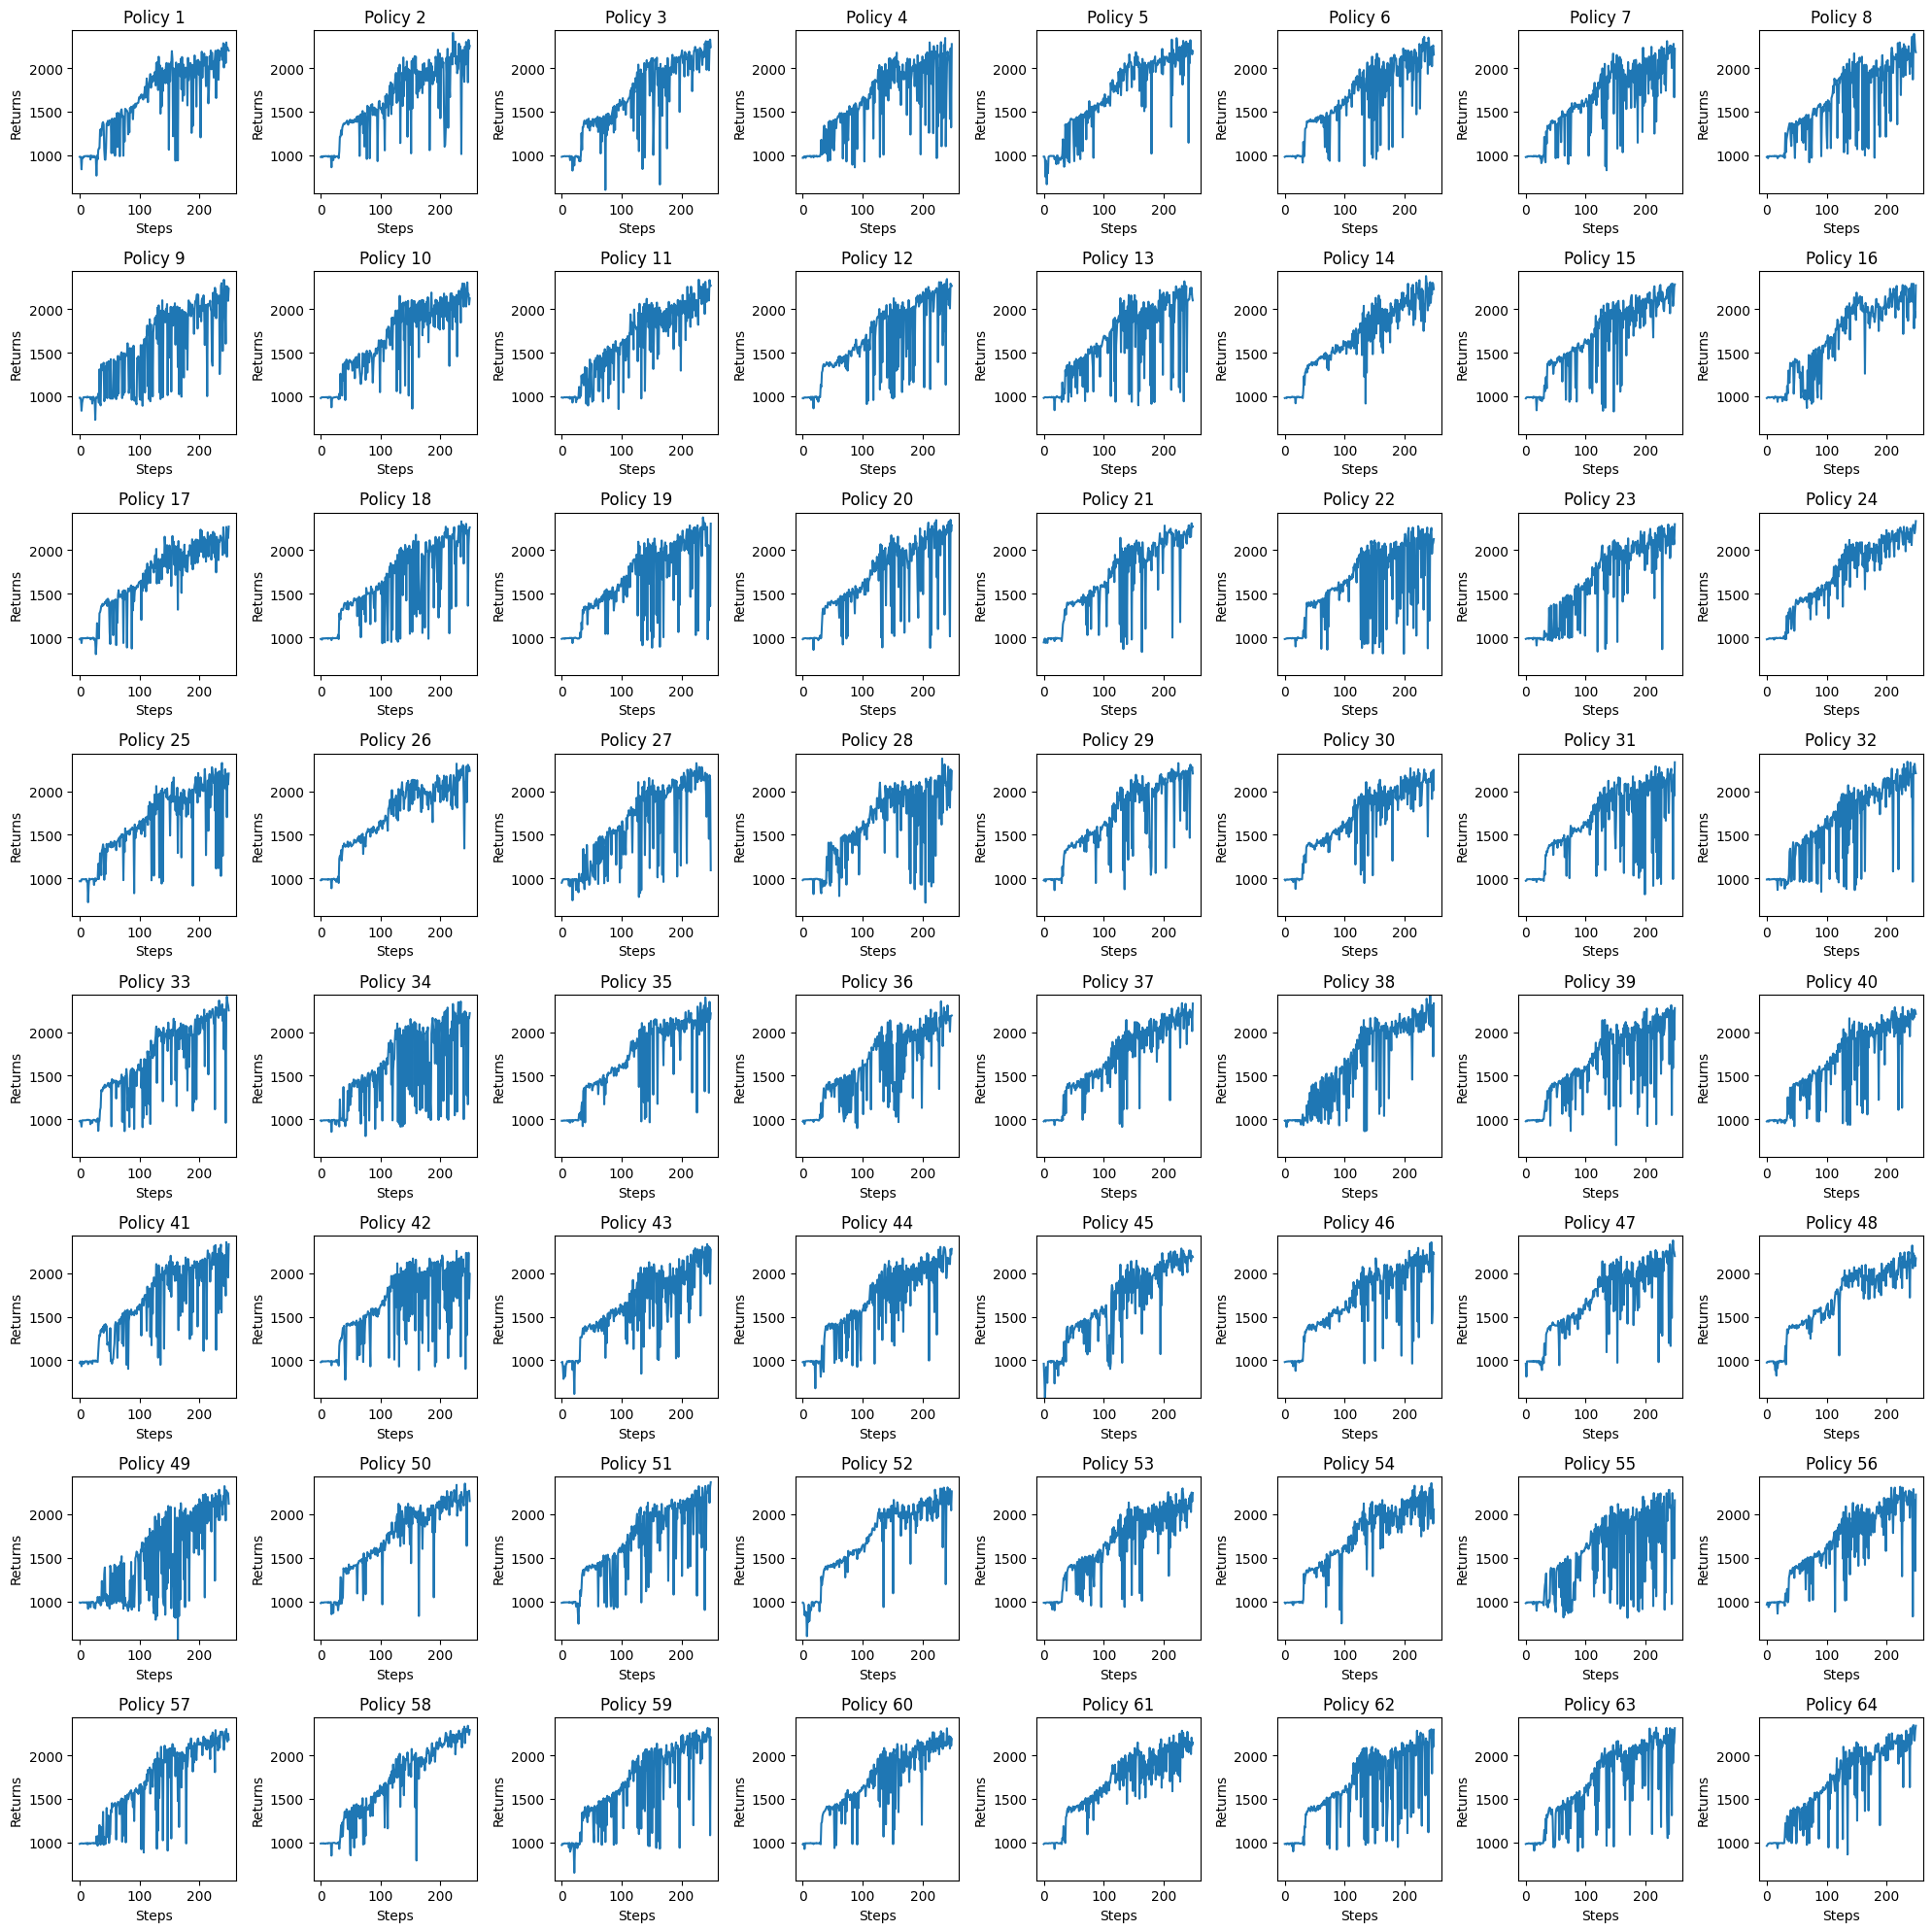

In [15]:
returns = jnp.array(returns)

# Determine the overall min and max fitness values for setting y-axis limits
ymin = returns.min()
ymax = returns.max()

# Plotting
fig, axs = plt.subplots(8, 8, figsize=(20, 20))  # Adjust the subplot grid if needed
for i in range(64):
    ax = axs[i // 8, i % 8]  # This assumes a 8x8 grid of subplots
    ax.plot(returns[:, i])
    ax.set_title(f"Policy {i+1}")
    ax.set_xlabel('Steps')
    ax.set_ylabel('Returns')
    ax.set_ylim([ymin, ymax])  # Set the same y-axis limits for all subplots

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
import jax.numpy as jnp  # Assuming you are using jax.numpy as jnp

returns = []
old_params = init_params
for _ in range(250):
    new_params = me_mcpg_emitter.emitters[0].emit_mcpg(emitter_state, old_params)
    fitnesses, descriptors, extra_scores, random_key = scoring_fn(
        new_params, random_key
    )
    emitter_state = me_mcpg_emitter.emitters[0].state_update(
        emitter_state=emitter_state,
        repertoire=repertoire,
        genotypes=new_params,
        fitnesses=fitnesses,
        descriptors=descriptors,
        extra_scores=extra_scores,
    )
    old_params = new_params
    print(f"mean fitness: {fitnesses.mean()}")
    returns.append(fitnesses)

mean fitness: 950.5074462890625
mean fitness: 496.9293212890625
mean fitness: 139.08172607421875
mean fitness: 87.64270782470703
mean fitness: 72.96725463867188
mean fitness: 21.64914894104004
mean fitness: 14.398386001586914
mean fitness: 11.034757614135742
mean fitness: 10.026762008666992
mean fitness: 15.51070785522461
mean fitness: 8.88510513305664
mean fitness: 8.301993370056152
mean fitness: 7.7789459228515625
mean fitness: 5.614498138427734
mean fitness: 3.105617046356201
mean fitness: 3.6537764072418213
mean fitness: 1.6462693214416504
mean fitness: 3.286868095397949
mean fitness: 2.5049216747283936
mean fitness: 2.2285499572753906
mean fitness: 1.4791675806045532
mean fitness: 0.7833273410797119
mean fitness: 0.5165598392486572
mean fitness: 0.7255101799964905
mean fitness: 0.8956781625747681
mean fitness: 1.2052274942398071
mean fitness: 0.8838441371917725
mean fitness: 0.5036112070083618
mean fitness: 0.3914567232131958
mean fitness: 0.3738993704319
mean fitness: 0.416574627

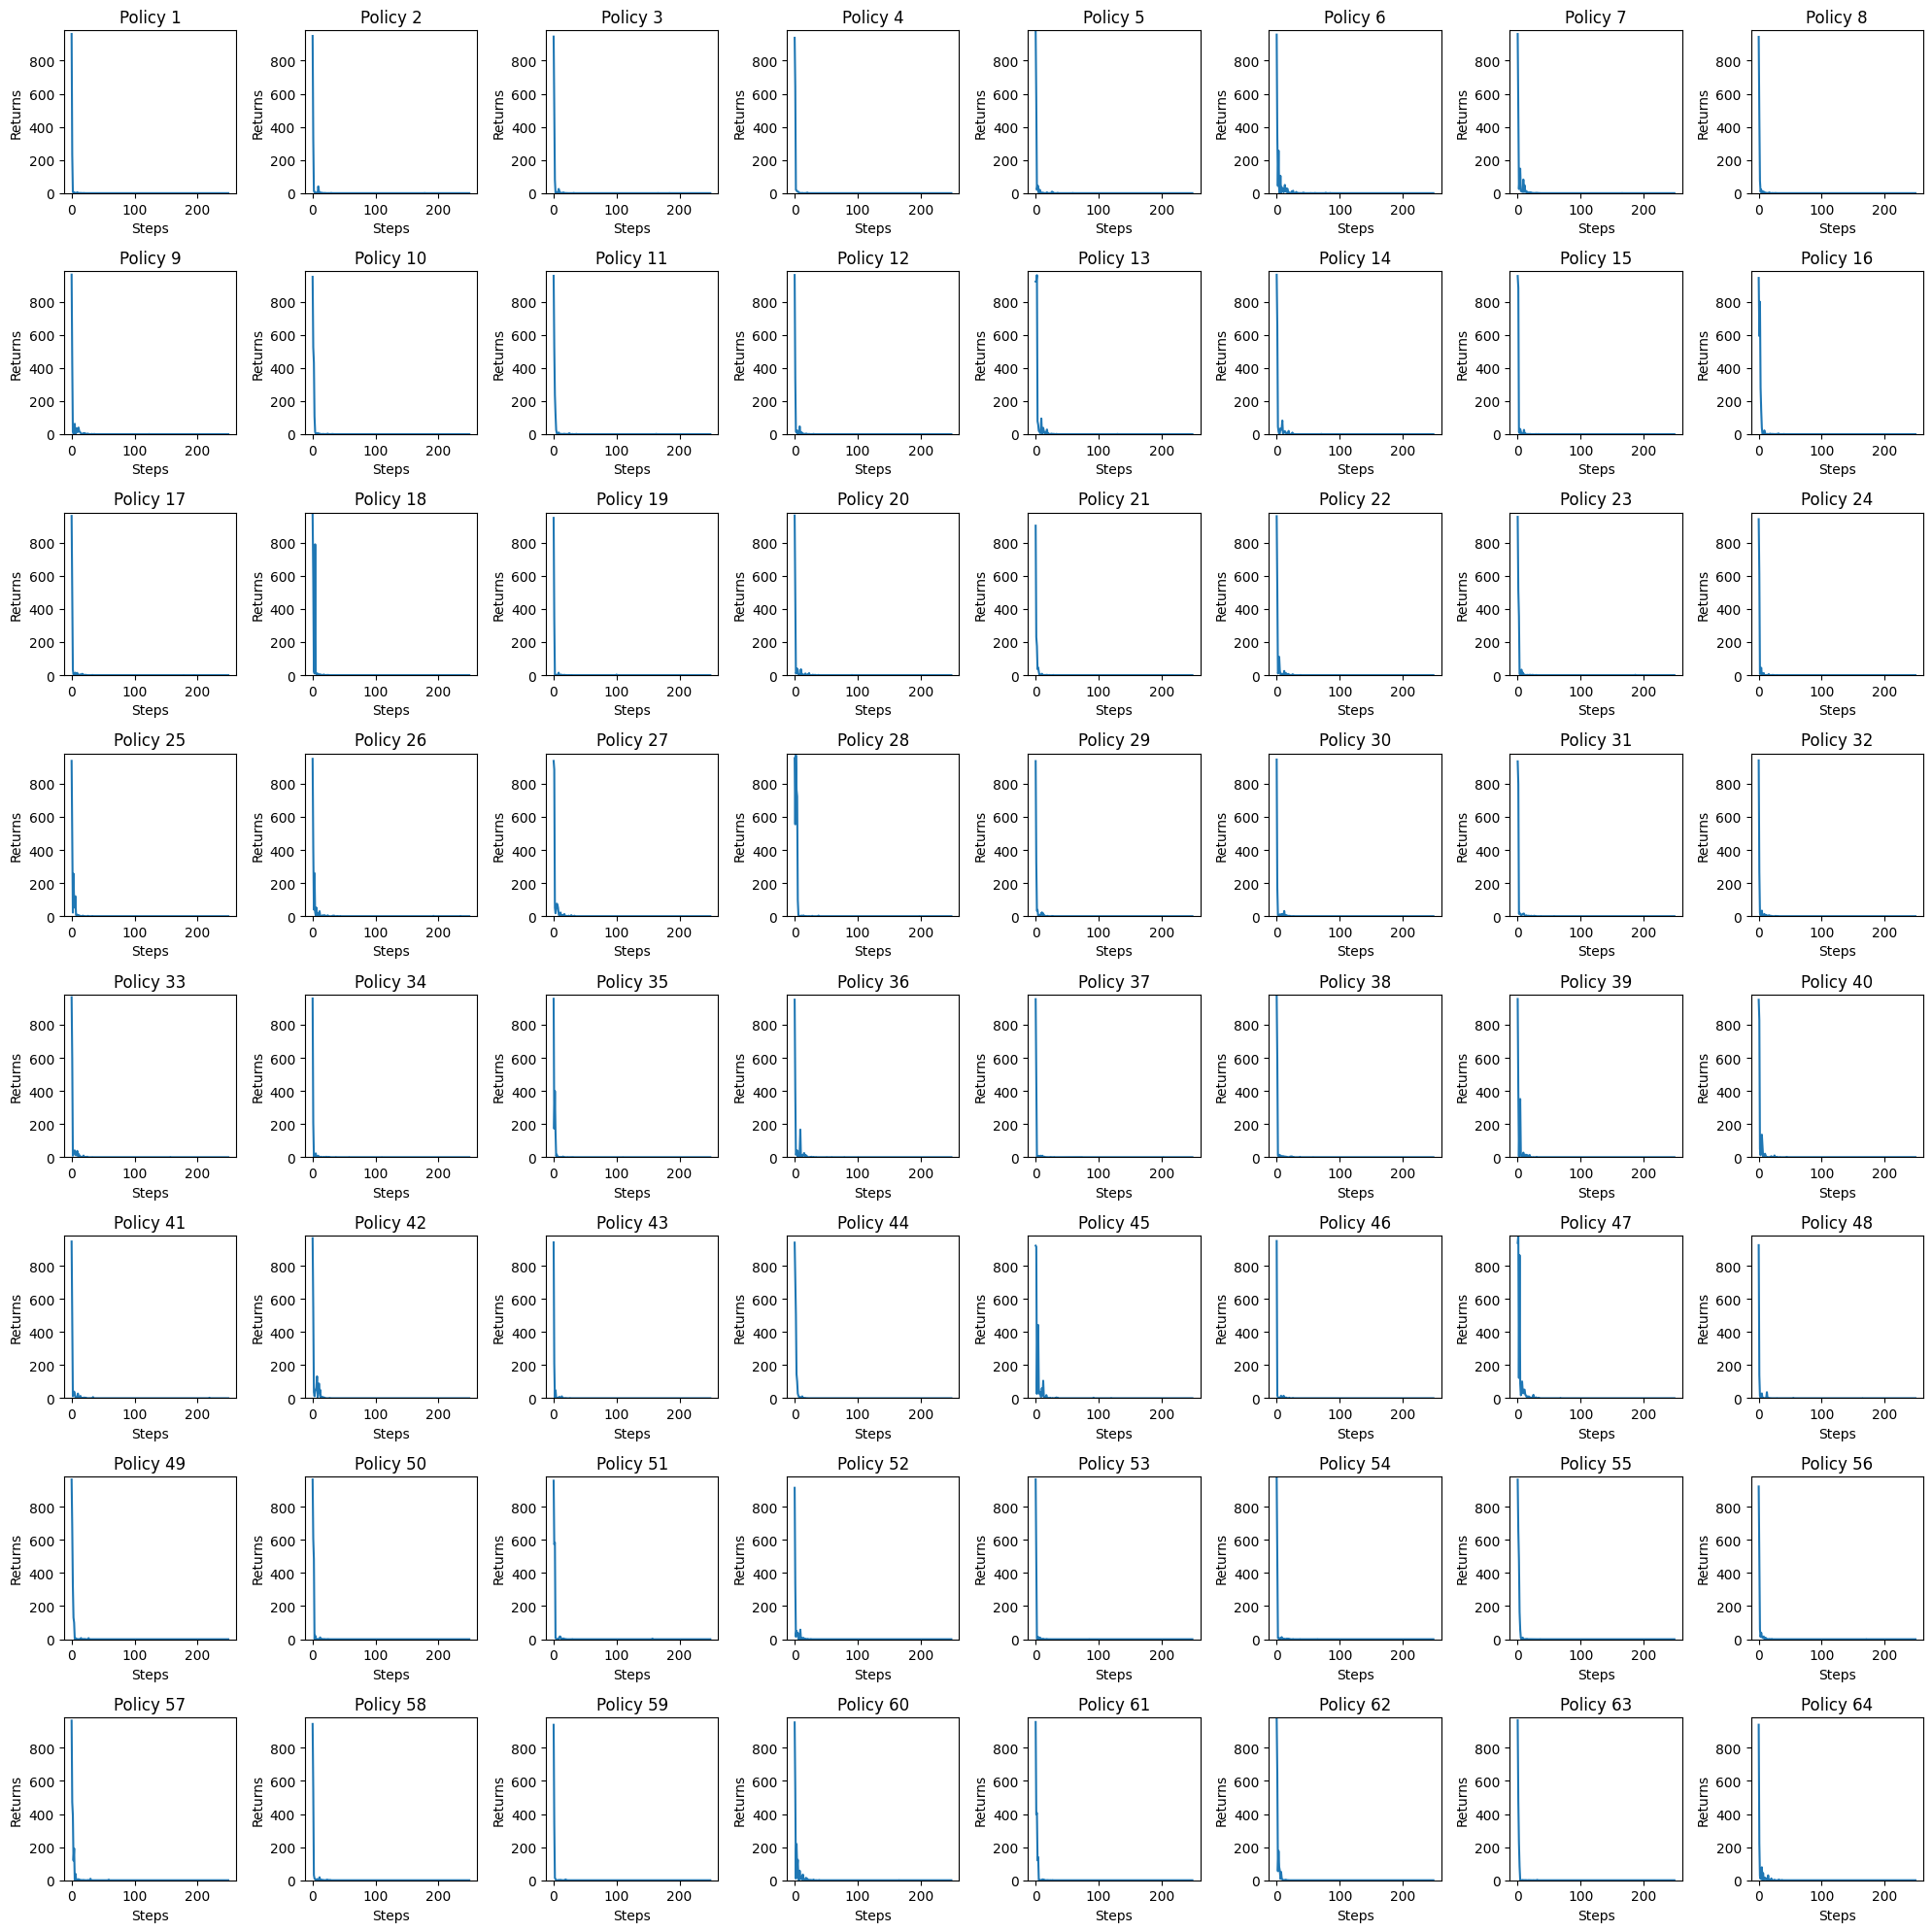

In [16]:
returns = jnp.array(returns)

# Determine the overall min and max fitness values for setting y-axis limits
ymin = returns.min()
ymax = returns.max()

# Plotting
fig, axs = plt.subplots(8, 8, figsize=(20, 20))  # Adjust the subplot grid if needed
for i in range(64):
    ax = axs[i // 8, i % 8]  # This assumes a 8x8 grid of subplots
    ax.plot(returns[:, i])
    ax.set_title(f"Policy {i+1}")
    ax.set_xlabel('Steps')
    ax.set_ylabel('Returns')
    ax.set_ylim([ymin, ymax])  # Set the same y-axis limits for all subplots

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
import jax.numpy as jnp  # Assuming you are using jax.numpy as jnp

returns = []
old_params = init_params
for _ in range(250):
    new_params = me_mcpg_emitter.emitters[0].emit_mcpg(emitter_state, old_params)
    fitnesses, descriptors, extra_scores, random_key = scoring_fn(
        new_params, random_key
    )
    emitter_state = me_mcpg_emitter.emitters[0].state_update(
        emitter_state=emitter_state,
        repertoire=repertoire,
        genotypes=new_params,
        fitnesses=fitnesses,
        descriptors=descriptors,
        extra_scores=extra_scores,
    )
    old_params = new_params
    print(f"mean fitness: {fitnesses.mean()}")
    returns.append(fitnesses)

mean fitness: 977.2542114257812
mean fitness: 979.4353637695312
mean fitness: 959.61962890625
mean fitness: 984.5986328125
mean fitness: 931.966796875
mean fitness: 982.1748046875
mean fitness: 981.358154296875
mean fitness: 951.3842163085938
mean fitness: 987.9535522460938
mean fitness: 944.5363159179688
mean fitness: 985.1196899414062
mean fitness: 967.5152587890625
mean fitness: 985.1976318359375
mean fitness: 951.0875244140625
mean fitness: 986.5292358398438
mean fitness: 955.661376953125
mean fitness: 992.4580078125
mean fitness: 964.2086181640625
mean fitness: 992.0026245117188
mean fitness: 944.7882080078125
mean fitness: 949.330322265625
mean fitness: 984.4270629882812
mean fitness: 953.6235961914062
mean fitness: 983.5281372070312
mean fitness: 937.308349609375
mean fitness: 980.5380859375
mean fitness: 987.4619140625
mean fitness: 946.9737548828125
mean fitness: 979.679931640625
mean fitness: 959.2459106445312
mean fitness: 982.9847412109375
mean fitness: 971.5528564453125
me

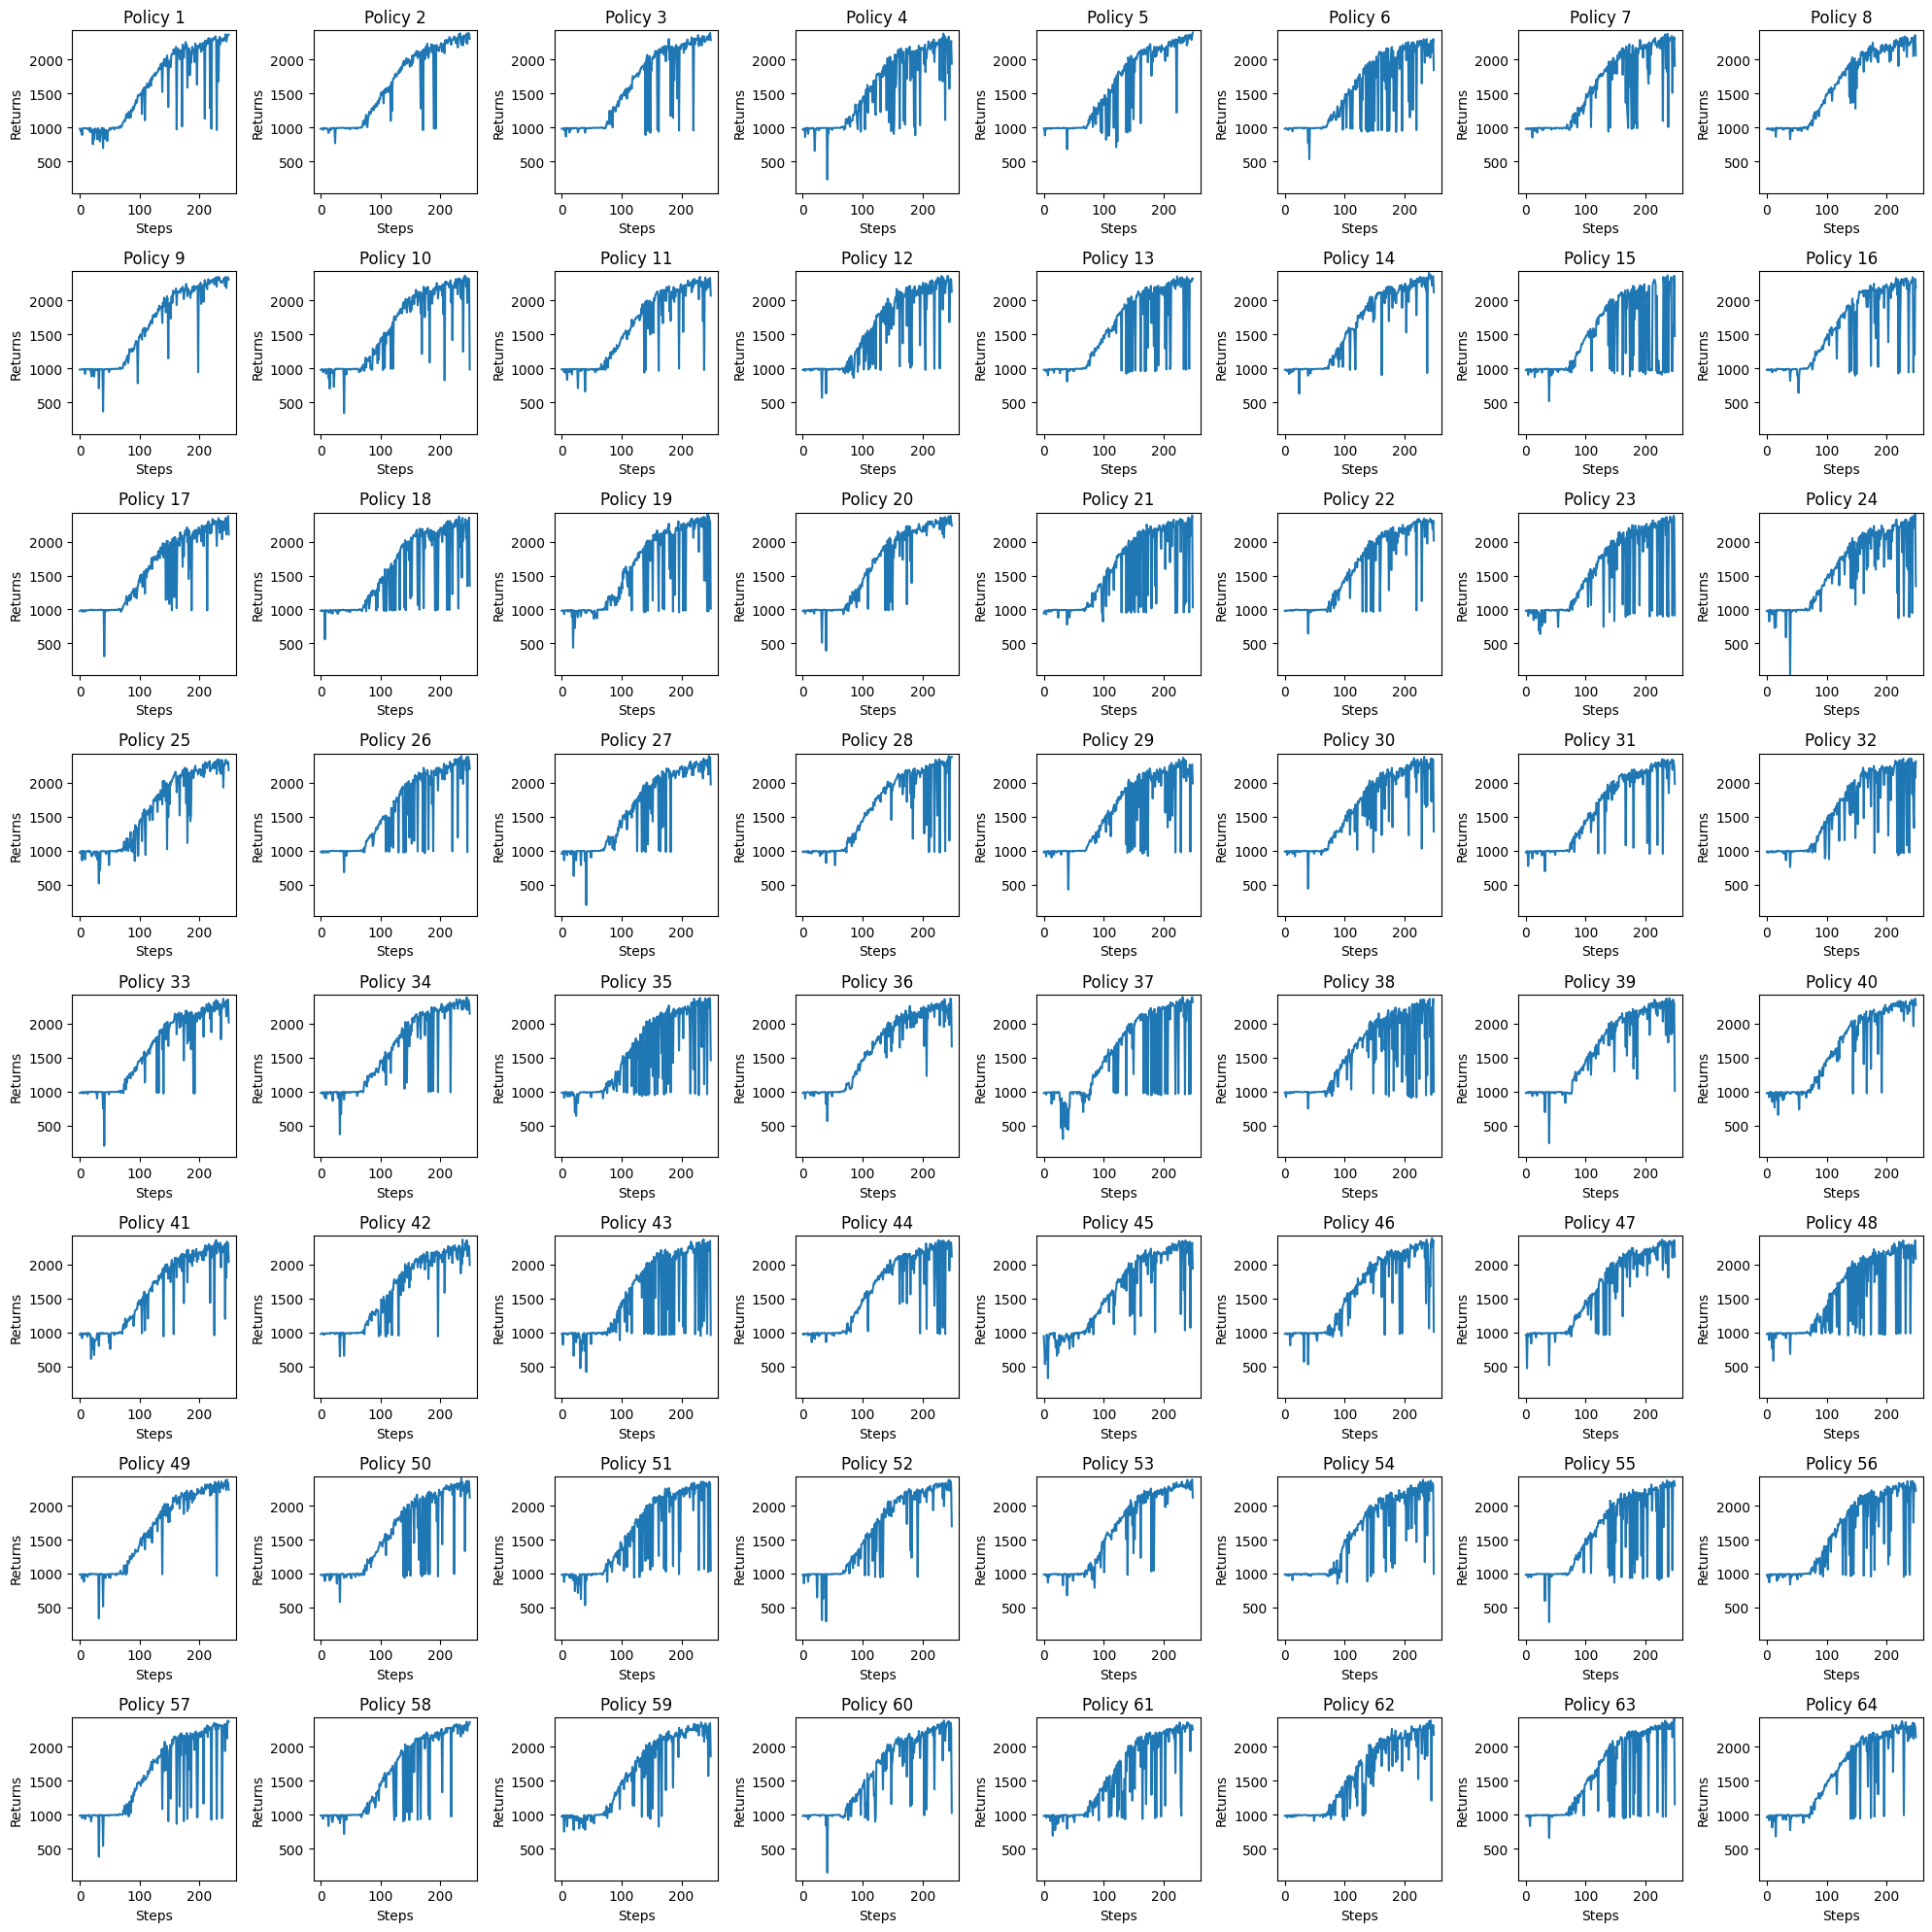

In [15]:
returns = jnp.array(returns)

# Determine the overall min and max fitness values for setting y-axis limits
ymin = returns.min()
ymax = returns.max()

# Plotting
fig, axs = plt.subplots(8, 8, figsize=(20, 20))  # Adjust the subplot grid if needed
for i in range(64):
    ax = axs[i // 8, i % 8]  # This assumes a 8x8 grid of subplots
    ax.plot(returns[:, i])
    ax.set_title(f"Policy {i+1}")
    ax.set_xlabel('Steps')
    ax.set_ylabel('Returns')
    ax.set_ylim([ymin, ymax])  # Set the same y-axis limits for all subplots

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
import jax.numpy as jnp  # Assuming you are using jax.numpy as jnp

returns = []
old_params = init_params
for _ in range(250):
    new_params = me_mcpg_emitter.emitters[0].emit_mcpg(emitter_state, old_params)
    fitnesses, descriptors, extra_scores, random_key = scoring_fn(
        new_params, random_key
    )
    emitter_state = me_mcpg_emitter.emitters[0].state_update(
        emitter_state=emitter_state,
        repertoire=repertoire,
        genotypes=new_params,
        fitnesses=fitnesses,
        descriptors=descriptors,
        extra_scores=extra_scores,
    )
    old_params = new_params
    print(f"mean fitness: {fitnesses.mean()}")
    returns.append(fitnesses)
    

mean fitness: 976.3272094726562
mean fitness: 979.97705078125
mean fitness: 942.6011352539062
mean fitness: 964.9736328125
mean fitness: 900.2108764648438
mean fitness: 946.98681640625
mean fitness: 912.8546142578125
mean fitness: 894.2584228515625
mean fitness: 849.5142822265625
mean fitness: 946.1618041992188
mean fitness: 922.3250732421875
mean fitness: 949.2843017578125
mean fitness: 934.9093017578125
mean fitness: 940.51220703125
mean fitness: 961.6217651367188
mean fitness: 903.368408203125
mean fitness: 955.0526123046875
mean fitness: 938.7305908203125
mean fitness: 964.01904296875
mean fitness: 904.0238037109375
mean fitness: 922.50146484375
mean fitness: 804.2783813476562
mean fitness: 846.6031494140625
mean fitness: 903.7769775390625
mean fitness: 961.226806640625
mean fitness: 925.692626953125
mean fitness: 960.5211181640625
mean fitness: 942.6170654296875
mean fitness: 966.1410522460938
mean fitness: 637.613525390625
mean fitness: 960.2233276367188
mean fitness: 926.7095947

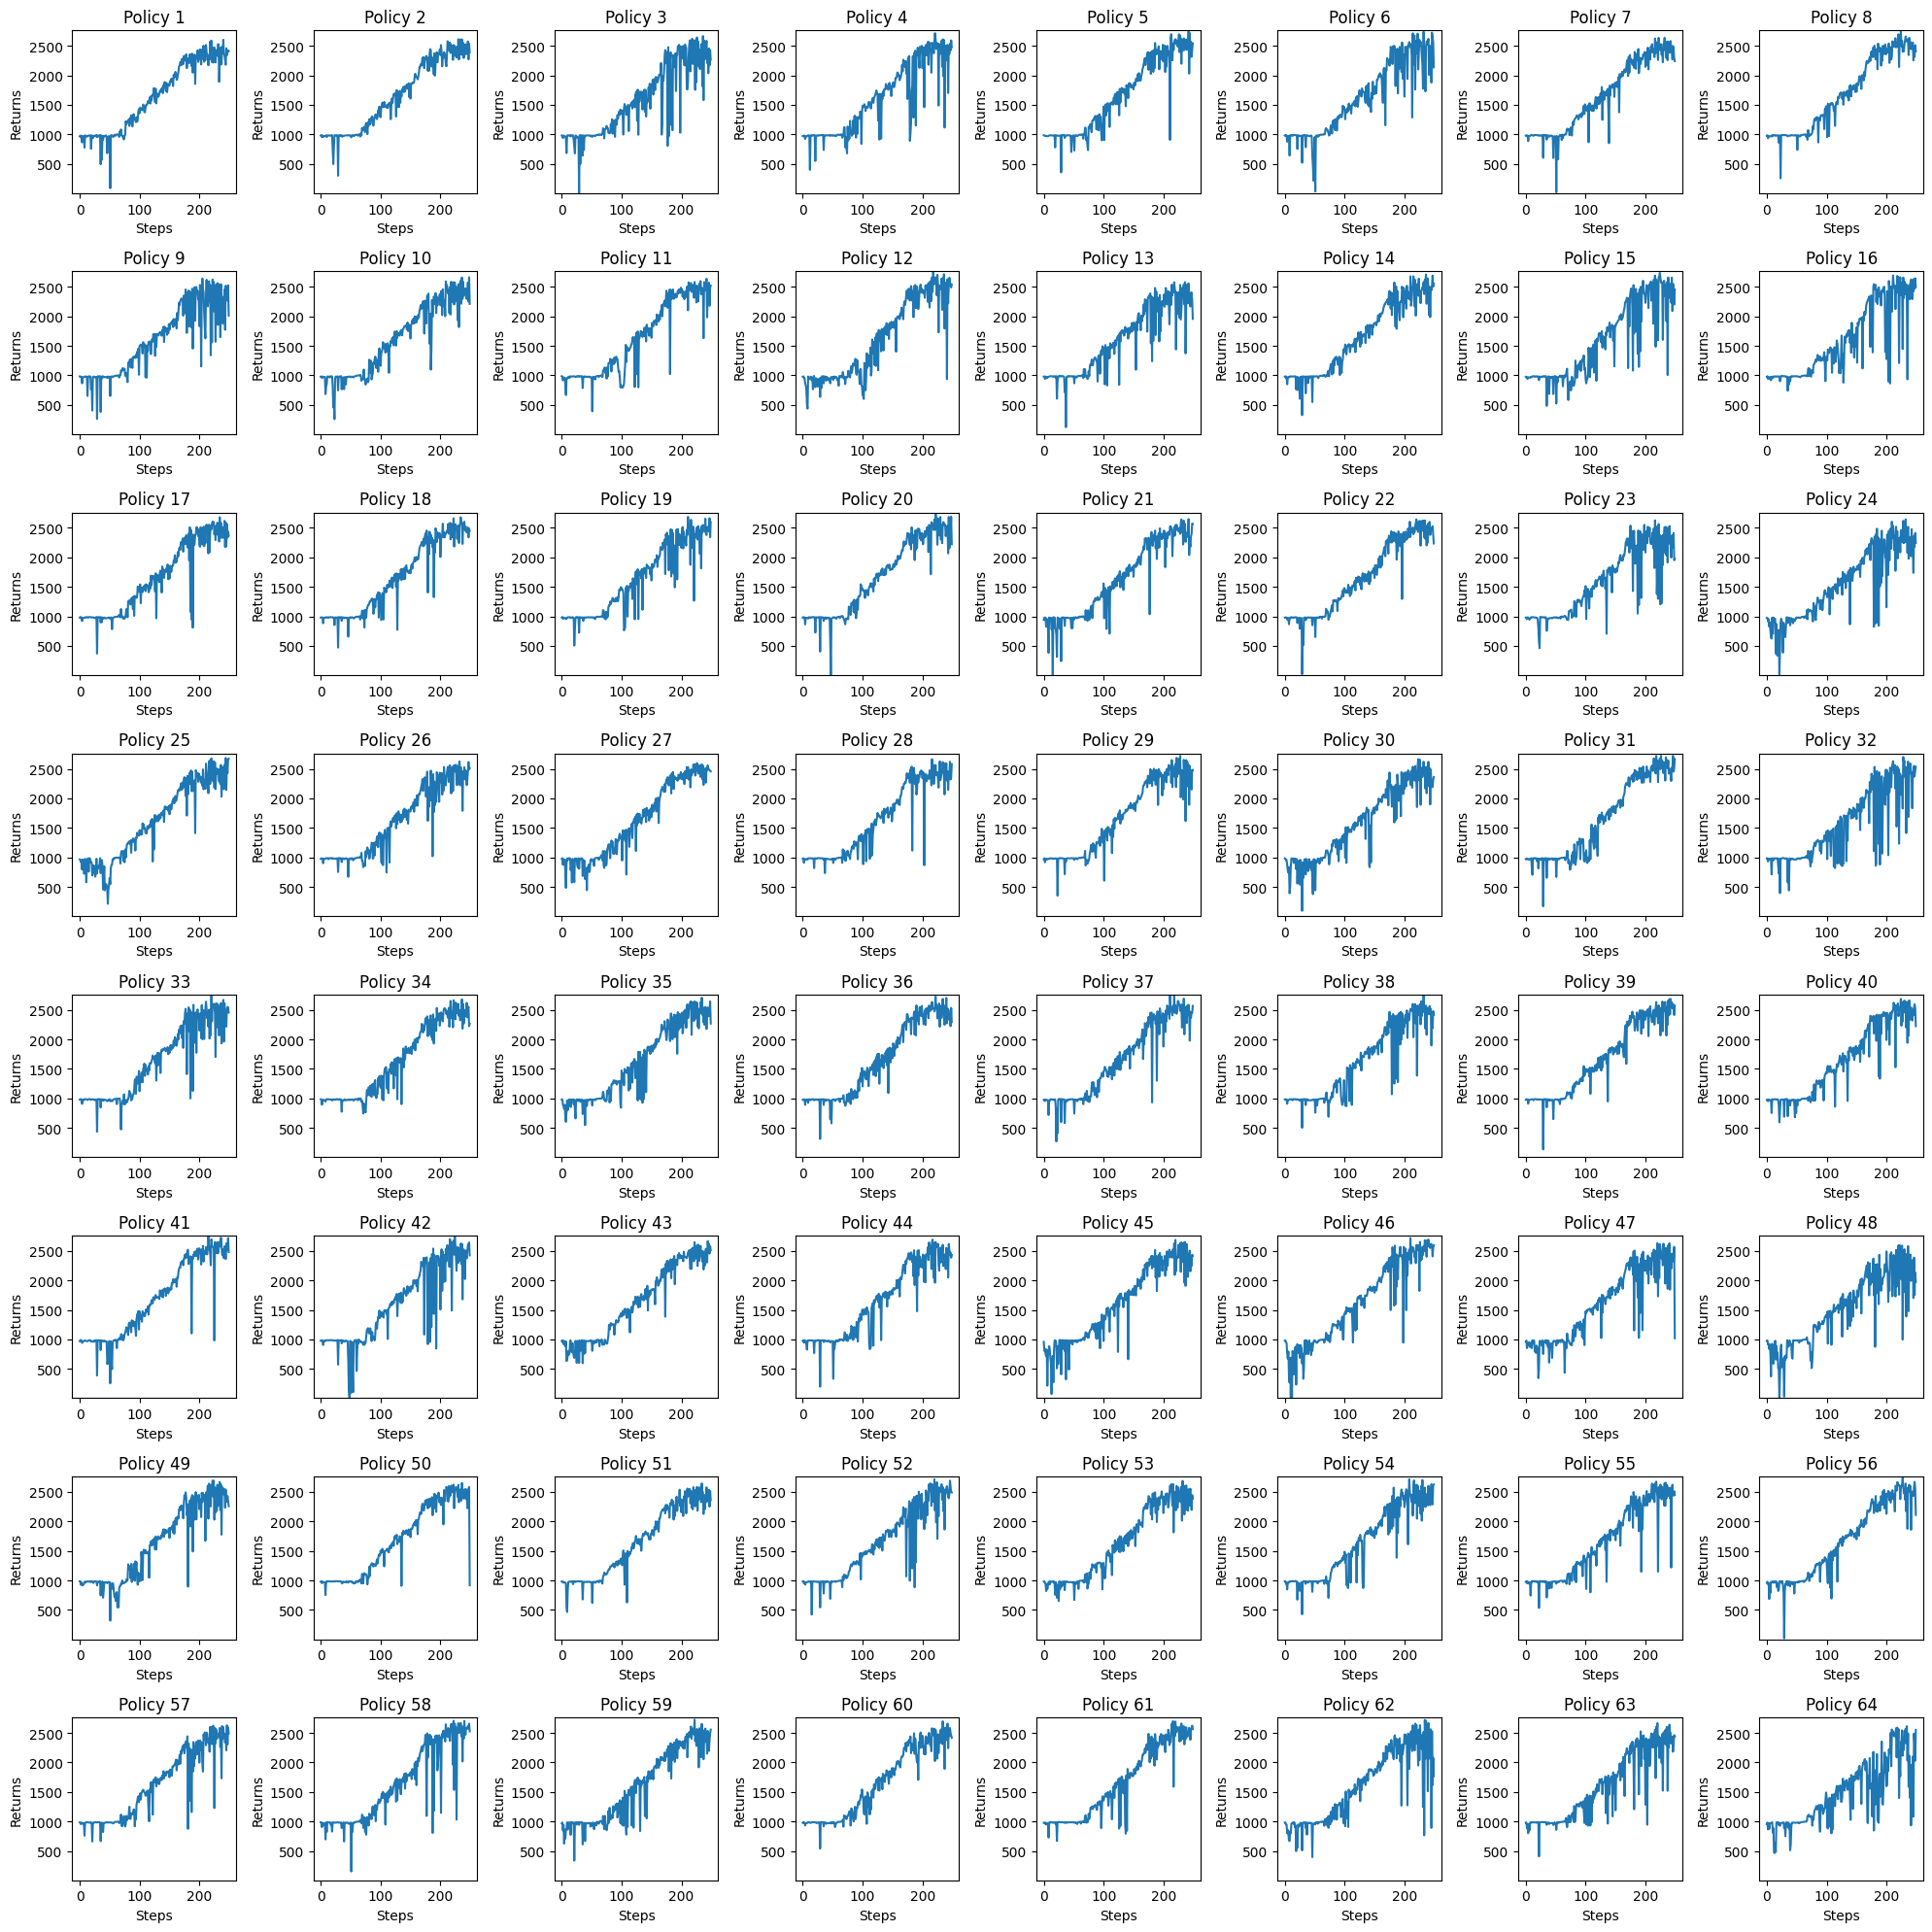

In [15]:
returns = jnp.array(returns)

# Determine the overall min and max fitness values for setting y-axis limits
ymin = returns.min()
ymax = returns.max()

# Plotting
fig, axs = plt.subplots(8, 8, figsize=(20, 20))  # Adjust the subplot grid if needed
for i in range(64):
    ax = axs[i // 8, i % 8]  # This assumes a 8x8 grid of subplots
    ax.plot(returns[:, i])
    ax.set_title(f"Policy {i+1}")
    ax.set_xlabel('Steps')
    ax.set_ylabel('Returns')
    ax.set_ylim([ymin, ymax])  # Set the same y-axis limits for all subplots

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()